In [1]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy

# Data

In [2]:
#read the datasets
train = pd.read_csv("./data.csv")
X, y = np.array(train[['Feature1','Feature2']]), np.array(train[['Target']])
y = y.squeeze()

In [3]:
X.shape

(500, 2)

In [4]:
y.shape

(500,)

# Model

In [5]:
# https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/1.%20ANN/1.1%20Introduction%20-%20Deep%20Learning%20and%20ANN.ipynb
import random
random.seed(123)

# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

In [6]:
# Make a matrix 
def makeMatrix(I, J, fill=0.0):
    return np.zeros([I,J])

In [7]:
# our sigmoid function
def sigmoid(x):
    #return math.tanh(x)
    return 1/(1+np.exp(-x))

In [8]:
# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return y - y**2

In [9]:
class MLP:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
        

    def backPropagate(self, targets, N, M):
        
        if len(targets) != self.no:
            print(targets)
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = np.zeros(self.no)
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        hidden_deltas = np.zeros(self.nh)
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] += N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] += N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*(targets[k]-self.ao[k])**2
        return error


    def test(self, patterns):
        self.predict = np.empty([len(patterns), self.no])
        for i, p in enumerate(patterns):
            self.predict[i] = self.activate(p)
            #self.predict[i] = self.activate(p[0])
            
    def activate(self, inputs):
        
        if len(inputs) != self.ni-1:
            print(inputs)
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh):
            sum_h = 0.0
            for i in range(self.ni):
                sum_h += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum_h)

        # output activations
        for k in range(self.no):
            sum_o = 0.0
            for j in range(self.nh):
                sum_o += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum_o)

        return self.ao[:]
    

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        patterns = list(patterns)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.activate(inputs)
                error += self.backPropagate([targets], N, M)
            if i % 5 == 0:
                print('error in interation %d : %-.5f' % (i,error))
            print('Final training error: %-.5f' % error)

In [10]:
# create a network with two inputs, one hidden, and one output nodes
ann = MLP(2, 1, 1)

%timeit -n 1 -r 1 ann.train(zip(X,y), iterations=2)

error in interation 0 : 53.62995
Final training error: 53.62995
Final training error: 47.35136
30.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
ann.test(X)

In [12]:
prediction = pd.DataFrame(data=np.array([y, np.ravel(ann.predict)]).T, 
                          columns=["actual", "prediction"])
prediction.head()

,actual,prediction
0,1.0,0.491100
1,1.0,0.495469
2,0.0,0.097362
3,0.0,0.400006
4,1.0,0.489664


In [13]:
# This generates the contour plot to show the decision boundary visually
def plot_decision_boundary(nn_model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    nn_model.test(np.c_[xx.ravel(), yy.ravel()])
    Z = nn_model.predict
    Z[Z>=0.5] = 1
    Z[Z<0.5] = 0
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], s=40,  c=y, cmap=plt.cm.BuGn)

Text(0.5, 1.0, 'Our initial model')

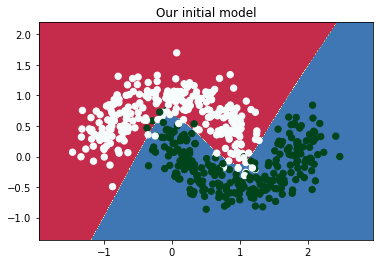

In [17]:
plot_decision_boundary(ann)
plt.title("Our initial model")

In [16]:
ann = MLP(2, 16, 1)
%timeit -n 1 -r 1 ann.train(zip(X,y), iterations=100)

error in interation 0 : 28.73468
Final training error: 28.73468
Final training error: 25.52037
Final training error: 25.39401
Final training error: 25.35357
Final training error: 25.31454
error in interation 5 : 25.26887
Final training error: 25.26887
Final training error: 25.21815
Final training error: 25.16502
Final training error: 25.11171
Final training error: 25.05978
error in interation 10 : 25.01018
Final training error: 25.01018
Final training error: 24.96340
Final training error: 24.91960
Final training error: 24.87873
Final training error: 24.84062
error in interation 15 : 24.80504
Final training error: 24.80504
Final training error: 24.77175
Final training error: 24.74053
Final training error: 24.71116
Final training error: 24.68345
error in interation 20 : 24.65726
Final training error: 24.65726
Final training error: 24.63244
Final training error: 24.60891
Final training error: 24.58656
Final training error: 24.56534
error in interation 25 : 24.54520
Final training error: 2